C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10..  Train Loss: 1.314..  Test Loss: 12.902..  Train Accuracy: 0.572..  Test Accuracy: 0.305..  Time: 220.43s
Epoch: 2/10..  Train Loss: 0.802..  Test Loss: 1.687..  Train Accuracy: 0.754..  Test Accuracy: 0.601..  Time: 171.50s
Epoch: 3/10..  Train Loss: 0.663..  Test Loss: 1.896..  Train Accuracy: 0.782..  Test Accuracy: 0.661..  Time: 171.22s
Epoch: 4/10..  Train Loss: 0.554..  Test Loss: 0.775..  Train Accuracy: 0.817..  Test Accuracy: 0.719..  Time: 174.00s
Epoch: 5/10..  Train Loss: 0.489..  Test Loss: 0.684..  Train Accuracy: 0.837..  Test Accuracy: 0.756..  Time: 170.92s
Epoch: 6/10..  Train Loss: 0.505..  Test Loss: 0.704..  Train Accuracy: 0.830..  Test Accuracy: 0.803..  Time: 170.96s
Epoch: 7/10..  Train Loss: 0.525..  Test Loss: 1.306..  Train Accuracy: 0.827..  Test Accuracy: 0.693..  Time: 171.25s
Epoch: 8/10..  Train Loss: 0.504..  Test Loss: 0.881..  Train Accuracy: 0.828..  Test Accuracy: 0.774..  Time: 177.23s
Epoch: 9/10..  Train Loss: 0.501..  Test Loss: 

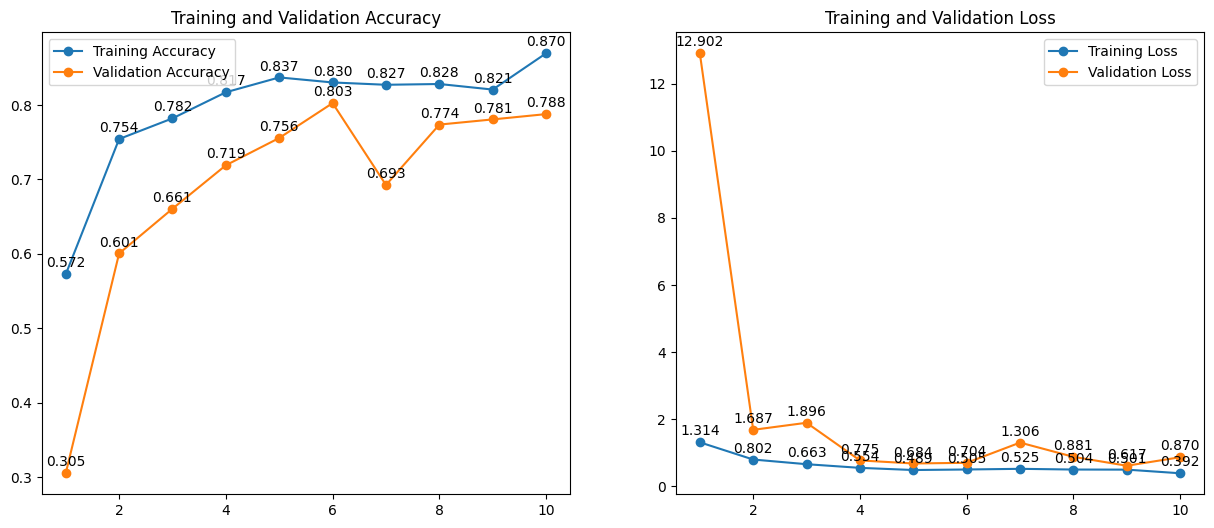

              precision    recall  f1-score   support

       Altin       0.89      1.00      0.94        25
       Gumus       1.00      0.46      0.63        26
     biotite       0.43      0.82      0.56        11
     bornite       0.76      0.63      0.69        30
 chrysocolla       0.81      0.88      0.84        33
   malachite       0.95      0.84      0.89        49
   muscovite       0.58      0.85      0.69        13
      pyrite       0.55      0.73      0.63        15
      quartz       0.91      0.86      0.89        36

    accuracy                           0.79       238
   macro avg       0.76      0.79      0.75       238
weighted avg       0.83      0.79      0.79       238



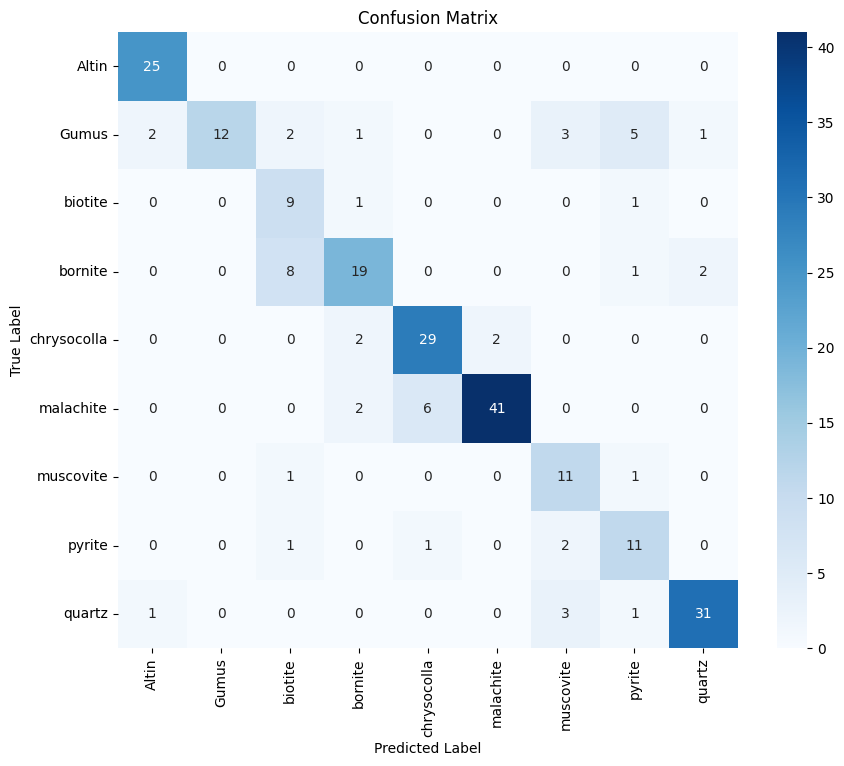

In [2]:
import time
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


root_folder = 'C:/Users/hp/Desktop/hhh/haz/minet'
target_labels = ['Altin', 'Gumus', 'biotite', 'bornite', 'chrysocolla', 'malachite', 'muscovite', 'pyrite', 'quartz']


transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder(root=root_folder, transform=transform)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# ResNet50
model_resnet = models.resnet50(pretrained=True)
model_resnet.fc = nn.Sequential(
    nn.Linear(model_resnet.fc.in_features, len(target_labels)),
    nn.LogSoftmax(dim=1)  
)
model_resnet.to(device)

# Loss and optimizer
criterion_resnet = nn.NLLLoss()
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)

# Training function
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    train_losses = []
    test_losses = []
    train_accu = []
    val_accu = []
    fit_time = time.time()

    for e in range(epochs):
        since = time.time()
        running_loss = 0
        train_acc = 0
#تذكير 
        model.train()
        for image, label in train_loader:
            optimizer.zero_grad()
            image, label = image.to(device), label.to(device)

            output = model(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, top_class = output.topk(1, dim=1)
            correct = top_class == label.view(*top_class.shape)
            train_acc += correct.type(torch.FloatTensor).mean()

        model.eval()
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            for image, label in val_loader:
                image, label = image.to(device), label.to(device)

                output = model(image)
                loss = criterion(output, label)

                _, top_class = output.topk(1, dim=1)
                correct = top_class == label.view(*top_class.shape)
                accuracy += correct.type(torch.FloatTensor).mean()

                test_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(val_loader))
        train_accu.append(train_acc / len(train_loader))
        val_accu.append(accuracy / len(val_loader))

        print("Epoch: {}/{}.. ".format(e + 1, epochs),
              "Train Loss: {:.3f}.. ".format(running_loss / len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss / len(val_loader)),
              "Train Accuracy: {:.3f}.. ".format(train_acc / len(train_loader)),
              "Test Accuracy: {:.3f}.. ".format(accuracy / len(val_loader)),
              "Time: {:.2f}s".format((time.time() - since)))

    history = {'train_loss': train_losses, 'val_loss': test_losses,
               'train_accuracy': train_accu, 'val_accuracy': val_accu}
    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))
    return history

epochs_resnet = 10
history_resnet = fit(epochs_resnet, model_resnet, train_loader, test_loader, criterion_resnet, optimizer_resnet)

def plot_loss(history, epochs):
    plt.plot(range(1, epochs+1), history['train_loss'], label='Training Loss')
    plt.plot(range(1, epochs+1), history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

def accuracy_loss(history, epochs):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), history['train_accuracy'], marker='o', linestyle='-', label='Training Accuracy')
    plt.plot(range(1, epochs+1), history['val_accuracy'], marker='o', linestyle='-', label='Validation Accuracy')
    for i, txt in enumerate(history['train_accuracy']):
        plt.annotate(f'{txt:.3f}', (i+1, txt), textcoords="offset points", xytext=(0, 5), ha='center')
    for i, txt in enumerate(history['val_accuracy']):
        plt.annotate(f'{txt:.3f}', (i+1, txt), textcoords="offset points", xytext=(0, 5), ha='center')
    plt.legend(loc='upper left')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), history['train_loss'], marker='o', linestyle='-', label='Training Loss')
    plt.plot(range(1, epochs+1), history['val_loss'], marker='o', linestyle='-', label='Validation Loss')
    for i, txt in enumerate(history['train_loss']):
        plt.annotate(f'{txt:.3f}', (i+1, txt), textcoords="offset points", xytext=(0, 5), ha='center')
    for i, txt in enumerate(history['val_loss']):
        plt.annotate(f'{txt:.3f}', (i+1, txt), textcoords="offset points", xytext=(0, 5), ha='center')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

accuracy_loss(history_resnet, epochs_resnet)

# Evaluation
model_resnet.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_predictions, target_names=target_labels))

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [4]:
print("training :", len(train_dataset))
print("test :", len(test_dataset))


training : 951
test : 238
